## ModelOptions vs SolverOptions


The distinction between **`ModelOptions`** and **`SolverOptions`** is essential when working with `OptiWindNet`.
This notebook presents a clear and structured explanation of their roles and differences:

- **`ModelOptions`** define *how the optimization problem is formulated*, including structural assumptions and model features such as topology type, feeder constraints, and balancing requirements.
- **`SolverOptions`** configure *how the underlying solver behaves during execution*, controlling aspects like time limits, optimality gaps, and so on.

Understanding this separation helps ensure that models are both correctly formulated and efficiently solved.

---

### 🔧 What is `ModelOptions`?

`ModelOptions` is a configuration object or dictionary that **controls how the mathematical model is built and behaves**, regardless of the solver used. These options are typically **high-level**, problem-specific settings that:

* Affect the **structure** of the model (e.g., topology type)
* Enable or disable **features** (e.g., balancing constraints)
* Influence **heuristic/metaheuristic behavior** if used

#### ✅ Examples of `ModelOptions`:

| Parameter      | Description                                                                 |
| -------------- | --------------------------------------------------------------------------- |
| `topology`     | Controls whether the solution allows "radial" or "branched" subtrees        |
| `feeder_route` | Determines if feeder paths must be "straight" or may be "segmented"         |
| `feeder_limit` | Specifies limits on the number of feeders used in the solution              |
| `balanced`     | Whether subtree loads must be balanced                                      |
| `max_feeders`  | Required when `feeder_limit="specified"` to indicate the max number allowed |

These options **change the formulation** of the problem before it is handed to the solver.

### Capability of different routers

| Router           | Topology                                                              | Feeder Route                                                      | Feeder Limit                                                    |
|------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------|------------------------------------------------------------------|
| **Heuristic**      | May produce *branched* or *radial* topologies; not user-controllable | **EW**: May yield *straight* or *segmented* routes; no control available  - **CPEW**: Always gives direct feeder-routes | Not controllable                                                 |
| **Metaheuristic**  | Always produces *radial* topology                                     | May yield *straight* or *segmented* routes; not user-controllable | Controllable via `feeder_limit` parameter in `ModelOptions`              |
| **MILP**           | Fully controllable via `topology` parameter in `ModelOptions`         | Fully controllable via `feeder_route` parameter in `ModelOptions`                   | Fully controllable via `feeder_limit` parameter in `ModelOptions`   |


In [1]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MetaHeuristic, MILP, ModelOptions, load_repository

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

Access ModelOptions help

In [3]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



## Optimize an examplary location

### Initialize Moray East

>In this example, the `load_repository()` functionality is used to load a prebuilt *Networkx.Graph*. For more details on this functionality look into the notebook about [Load repositories containing location data](api_02-load-repositories.ipynb).

In [4]:
locations = load_repository()
wfn = WindFarmNetwork(L=locations.seagreen, cables=5)

<Axes: >

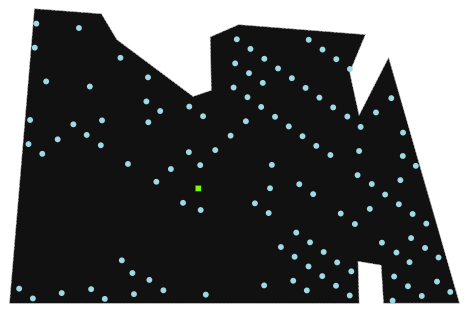

In [5]:
wfn.plot_location()

### Heuristic routers

**In the current version of `OptiWindNet`, `ModelOptions` are not supported by `Heuristic-Esau_Williams` and `Heuristic-CPEW`.**

* These solvers **do not accept `ModelOptions` as an argument**, and their behavior is unaffected by its settings.
* `CPEW` **always produces straight feeder routes** by design.
* Neither of the routers enforce **radial topologies** or **feeder limits**, even if such preferences are specified.

Optimize with `Heuristic-Esau_Williams`

<Axes: >

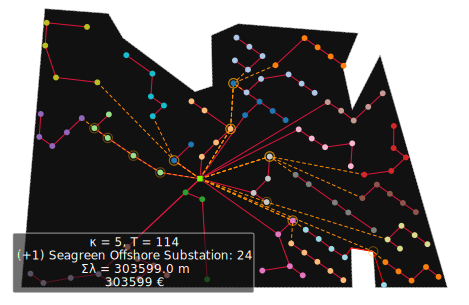

In [6]:
#
router_EW = Heuristic(solver_name='Esau_Williams')
res_EW= wfn.optimize(router=router_EW)
wfn.plot()

Optimize with `Heuristic-CPEW`

> Note that the feeder routes are direct.

<Axes: >

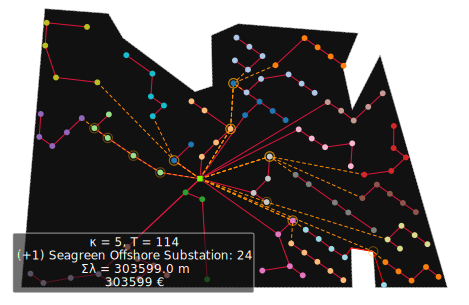

In [7]:
router_cpew = Heuristic(solver_name='CPEW')
res_cpew= wfn.optimize(router=router_cpew)
wfn.plot()

### Metaheuristic router (`HGS`)

**`Metaheuristic-HGS` does not support `ModelOptions` in its current format.**

* Instead, it accepts key configuration options, such as `feeder_limit` and `balanced`, as **individual arguments** passed directly to the router.

  * **Default values**:

    * `balanced = False`
    * `feeder_limit` is flexible and generally favors minimizing total cable length:

      * For locations with **one substation**, `feeder_limit` can be adjusted.
      * For locations with **multiple substations**, the `feeder_limit` argument is **ignored**, and the number of feeders is fixed to the **minimum required**.
* Other `ModelOptions` parameters, such as `topology` and `feeder_route`, are **not currently supported**.

<Axes: >

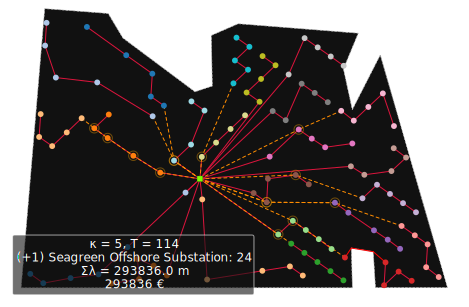

In [8]:
router_hgs = MetaHeuristic(solver_name='HGS', time_limit=2)
res_hgs= wfn.optimize(router=router_hgs)
wfn.plot()

Set the `feeder_limit` lower than the possible minimum.

Vehicle number (20) too low for feasibilty with capacity (5). Setting to 23.


<Axes: >

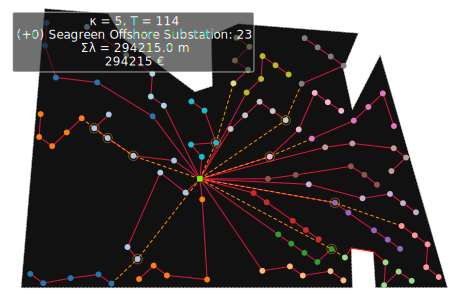

In [9]:
router_hgs = MetaHeuristic(solver_name='HGS', time_limit=2, feeder_limit=20)
res_hgs= wfn.optimize(router=router_hgs)
wfn.plot()

### ✅ MILP routers

For `MILP routers`, we run optimization with two sets of ModelOptions for comparison:


| Model Option   | Set 1       | Set 2       |
| -------------- | ----------- | ----------- |
| **topology**     | `branched`  | `radial`    |
| **feeder_limit** | `unlimited` | `minimum`   |
| **feeder_route** | `segmented` | `straight` |


With `MILP`, we observe the following behavior across different `ModelOptions` settings:

### First MILP Run (`model_options1`)

* **`topology='branched'`**, **`feeder_limit='unlimited'`**, **`feeder_route='segmented'`**

  The solver constructs a **branched** network structure without applying any limit on the number of feeders. The feeder routes follow a **segmented** (piecewise-straight) pattern, as specified. All aspects of the layout are consistent with the given `ModelOptions`.

  This solution can also serve as a **valid warm start** for subsequent optimizations.

### Second MILP Run (`model_options2`)

* **`topology='radial'`**, **`feeder_limit='minimum'`**, **`feeder_route='straight'`**

  The solver produces a strictly **radial** layout, explicitly minimizing the number of feeders. All feeder routes are **straight-line connections**, fully complying with the `feeder_route='straight'` constraint. This solution reflects all constraints imposed by the new set of `ModelOptions`.

  > Note: with this setting, none of the routers could secure warmstarting of the model.

### Summary

The `MILP` router strictly adheres to all provided `ModelOptions`:

* It guarantees enforcement of topology (`branched` vs. `radial`).
* It respects feeder constraints (`unlimited` vs. `minimum`).
* It conforms to the required routing structure (`segmented` vs. `straight`).


First run >>> 
Second run >>> 


<Axes: >

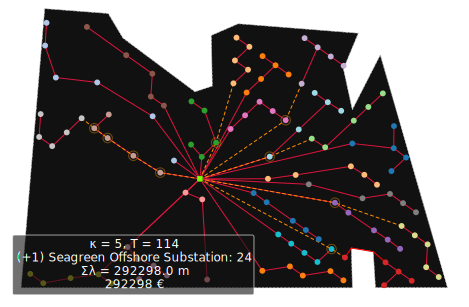

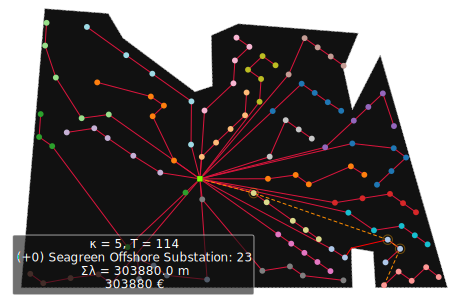

In [10]:
# create the logic of warmstarting for MILP
print('First run >>> ')
model_options1 = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',)

router_milp1 = MILP(solver_name='ortools', time_limit=30, mip_gap=0.01, model_options=model_options1)
res_milp1 = wfn.optimize(router=router_milp1)
wfn.plot()

print('Second run >>> ')

model_options2 = ModelOptions(
                        topology='radial',
                        feeder_limit='minimum',
                        feeder_route='straight',
)
router_milp2 = MILP(solver_name='ortools', time_limit=1000, mip_gap=0.01, model_options=model_options2)
res_milp2 = wfn.optimize(router=router_milp2)
wfn.plot()

### Warmstarter Compatibility with different `ModelOptions` setting.

| **Model Option** | **Value**     | **Warmstarter**         |
|------------------|---------------|-------------------------|
| **Feeder limit** | Unlimited     | ✅ all works           |
|                  | Minimum       | only Metaheuristic-HGS  |
| **Feeder route** | Straight      | only Heuristic-CPEW     |
|                  | Segmented     | ✅ all works           |
| **Topology**     | Branched      | ✅ all works            |
|                  | Radial        | only Metaheuristic-HGS  |


Few examples are run to further illustrate this table.


Example 1:

`topology='branched'`, `feeder_limit='unlimited'`, and `feeder_route='segmented'`: we expect all routers work as warmstarter.

In [11]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
wfn.optimize(router=router_EW)
#wfn.optimize(router=router_cpew)
router_milp1 = MILP(solver_name='ortools', time_limit=10, mip_gap=0.01, model_options=model_options, verbose=True)
res = wfn.optimize(router=router_milp1)

>>> Using warm start: the model is initialized with the provided solution S <<<

Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 10 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0x8e6c47d39c27f0fb)
#Variables: 2'396 (#bools: 1'198 in floating point objective) (2'168 primary variables)
  - 1'198 Booleans in [0,1]
  - 1'084 in [0,4]
  - 114 in [0,5]
#kAtMostOne: 931 (#literals: 2'828)
#kLinear1: 2'396 (#enforced: 2'396)
#kLinear3: 1
#kLinearN: 344 (#terms: 5'987)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 1198 terms with magnitude in [1003.68, 16848.9] average = 3444.22
[Scaling] Objective coefficient relative error: 2.02672e-10
[Scaling] Objective worst-case absolute error: 7.60977e-05
[Scaling] Objective scaling factor: 2.09715e+06
  2.23e-03s  0.00e+00d  [DetectDominanceRelations] 
  4.01e-02s  0.00e+00d  [ope

Example 1:

`topology='radial'`, `feeder_limit='unlimited'`, and `feeder_route='segmented'`: we expect only `MetaHeuristic-HGS` works as warmstarter.

In [12]:
model_options = ModelOptions(
                        topology='radial',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
wfn.optimize(router=router_EW)
#wfn.optimize(router=router_cpew)
router_milp = MILP(solver_name='ortools', time_limit=10, mip_gap=0.01, model_options=model_options, verbose=True)
res = wfn.optimize(router=router_milp)


    - branched structure not allowed under "radial" topology


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 10 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0x9aeb75ae3a596d57)
#Variables: 2'396 (#bools: 1'198 in floating point objective) (2'168 primary variables)
  - 1'198 Booleans in [0,1]
  - 1'084 in [0,4]
  - 114 in [0,5]
#kAtMostOne: 931 (#literals: 2'828)
#kLinear1: 2'396 (#enforced: 2'396)
#kLinear3: 2
#kLinearN: 457 (#terms: 7'068)

Starting presolve at 0.01s
The solution hint is complete, but it is infeasible! we will try to repair it.
[Scaling] Floating point objective has 1198 terms with magnitude in [1003.68, 16848.9] average = 3444.22
[Scaling] Objective coefficient relative error: 2.02672e-10
[Scaling] Objective worst-case absolute error: 7.60977e-05
[Scaling] Objective scaling factor: 2.09715e+06
  2.11e-03s  0.00e+00d  [DetectDominanceRelations] 
  4.59e-02s  

In [13]:
router_hgs = MetaHeuristic(solver_name='HGS', time_limit=2)
wfn.optimize(router=router_hgs)
res = wfn.optimize(router=router_milp)

>>> Using warm start: the model is initialized with the provided solution S <<<

Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 10 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0xa327c0acff9b212e)
#Variables: 2'396 (#bools: 1'198 in floating point objective) (2'168 primary variables)
  - 1'198 Booleans in [0,1]
  - 1'084 in [0,4]
  - 114 in [0,5]
#kAtMostOne: 931 (#literals: 2'828)
#kLinear1: 2'396 (#enforced: 2'396)
#kLinear3: 2
#kLinearN: 457 (#terms: 7'068)

Starting presolve at 0.02s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 1198 terms with magnitude in [1003.68, 16848.9] average = 3444.22
[Scaling] Objective coefficient relative error: 2.02672e-10
[Scaling] Objective worst-case absolute error: 7.60977e-05
[Scaling] Objective scaling factor: 2.09715e+06
  1.95e-03s  0.00e+00d  [DetectDominanceRelations] 
  4.58e-02s  0.00e+00d  [ope

### 🧮 What is `SolverOptions`?

`SolverOptions` refers to **solver-specific configuration parameters** that affect **how the solver works internally** (once the model is already built).

These settings are typically passed directly to a solver like CPLEX, Gurobi, CBC, etc., and influence:

* **Search strategy**
* **Runtime limits**
* **Optimality tolerances**
* **Logging and precision settings**

#### ✅ Common `SolverOptions` for MILP:

| Parameter      | Description                                           |
| -------------- | ----------------------------------------------------- |
| `time_limit`   | Maximum allowed solve time (in seconds)               |
| `gap`          | Optimality tolerance (e.g., 0.01 for 1% gap)          |
| `mip_emphasis` | Prioritize bound quality, feasibility, or integrality |
| `threads`      | Number of threads to use                              |

After initializing the router, `OptiWindNet` sets a set of default options internally to match OptiWindNet’s preferred values.

You can see the solveroptions modified by `OptiWindNet` after creating an instance of the MILP router via:

```python
router.optiwindnet_default_options
```

>If desired, set the logging level to `INFO` **before running `.optimize()` with the MILP router** to display detailed messages about the solver configuration:
>```python
>import logging
>logging.basicConfig(level=logging.INFO)
>```

In [14]:
router_ortools = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01,  verbose=True)
router_ortools.optiwindnet_default_options

{}

In [15]:
router_cplex = MILP(solver_name='cplex', time_limit=15, mip_gap=0.01,  verbose=True)
router_cplex.optiwindnet_default_options

{'parallel': -1, 'emphasis_mip': 4}

In [16]:
router_cbc = MILP(solver_name='cbc', time_limit=15, mip_gap=0.01,  verbose=True)
router_cbc.optiwindnet_default_options

{'threads': 8,
 'timeMode': 'elapsed',
 'nodeStrategy': 'downFewest',
 'Dins': 'on',
 'VndVariableNeighborhoodSearch': 'on',
 'Rens': 'on',
 'Rins': 'on',
 'pivotAndComplement': 'off',
 'proximitySearch': 'off',
 'gomoryCuts': 'on',
 'mixedIntegerRoundingCuts': 'on',
 'flowCoverCuts': 'on',
 'cliqueCuts': 'off',
 'twoMirCuts': 'off',
 'knapsackCuts': 'off',
 'probingCuts': 'off',
 'zeroHalfCuts': 'off',
 'liftAndProjectCuts': 'off',
 'residualCapacityCuts': 'off'}

In [17]:
router_cbc = MILP(solver_name='gurobi', time_limit=15, mip_gap=0.01,  verbose=True)
router_cbc.optiwindnet_default_options

{'mipfocus': 1}

In [18]:
router_cbc = MILP(solver_name='highs', time_limit=15, mip_gap=0.01,  verbose=True)
router_cbc.optiwindnet_default_options

{}

In [19]:
router_cbc = MILP(solver_name='scip', time_limit=15, mip_gap=0.01, verbose=True)
router_cbc.optiwindnet_default_options

{}

This attribute only reflects the options explicitly modified by OptiWindNet during initialization. MILP solvers typically support a much larger set of configurable options, which we can also adjust separately.
For a complete list of available options for each MILP solver, please refer to the corresponding solver's official documentation or user manual.
For example, in the case of the CBC solver, we can refer to its full list of options here:
[http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf](http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf)

> **Note:** Modifying any of the options originally set by OptiWindNet will not change the values stored in `optiwindnet_default_options`. However, the updated values will be used when solving the optimization problem.

Solver options—including those set by OptiWindNet as well as additional configurable parameters—can be modified by creating a **dictionary** and passing it to the router. The same approach applies to **model options**.

In [20]:
solver_options=dict(
    num_workers = 5,
)

router_ortools = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)

wfn.optimize(router=router_ortools)

>>> Using warm start: the model is initialized with the provided solution S <<<

Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 15 log_search_progress: true relative_gap_limit: 0.01 num_workers: 5

Initial optimization model '': (model_fingerprint: 0x345bb83acb4e402f)
#Variables: 2'396 (#bools: 1'198 in floating point objective) (2'168 primary variables)
  - 1'198 Booleans in [0,1]
  - 1'084 in [0,4]
  - 114 in [0,5]
#kAtMostOne: 931 (#literals: 2'828)
#kLinear1: 2'396 (#enforced: 2'396)
#kLinear3: 1
#kLinearN: 344 (#terms: 5'987)

Starting presolve at 0.01s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 1198 terms with magnitude in [1003.68, 16848.9] average = 3444.22
[Scaling] Objective coefficient relative error: 2.02672e-10
[Scaling] Objective worst-case absolute error: 7.60977e-05
[Scaling] Objective scaling factor: 2.09715e+06
  1.19e-03s  0.00e+00d  [DetectDominanceRelations] 
  3.00e-02s  0.00e+00d  [operations_research

array([ 25,  47,  24,  -1,  97,  65,  99,  -1,  -1,  58,  -1,   7,  81,
        34,  83,  84,  14,  33, 110,  91,  64,  27,  46,  19,  92,  -1,
        70,  -1,  -1,  53,  78,  -1, 100,  61, 102,  55,  80,  17,  30,
        19,  45,  -1,  22,  87,  64,   5,  -1,  26, 112,  -1,  94,  71,
         0,   8, 107,  31,  11,  77,  -1,  79, 104,  -1,  82,  -1,  21,
        -1,  69,  87,  -1,  93,  73,  48,  -1,  -1,   6,  74,  -1, 101,
        98,  55,  56,  -1,  90, 103,  63,  41, 106,  50,  68, 109,  -1,
       111,  88,   3,  -1,  51,  52,  29,  49,  72,  76,  81,   9,  10,
        32,  37,  62,  15,  40,  85,  42,  -1,  -1,  89])

### Key Differences between ModelOptions and SolverOptions

| Feature       | `ModelOptions`                                 | `SolverOptions`                           |
| ------------- | ---------------------------------------------- | ----------------------------------------- |
| Scope         | Problem formulation level                      | Solver execution level                    |
| Affects       | Model structure and constraints                | Search process and performance            |
| Applicable to | All methods (heuristics, metaheuristics, MILP) | Only MILP solvers and HGS    |
| Examples      | `topology`, `feeder_limit`, `balanced`         | `time_limit`, `gap`, `threads`            |
| Impact        | Determines **what** is solved                  | Determines **how** it's solved            |
| Defined by    | The modeling framework                         | The specific solver (e.g., CPLEX, Gurobi) |


### Summary

* **Use `ModelOptions`** to specify **what kind of solution** you want (structure, constraints, flexibility).
* **Use `SolverOptions`** to control **how long and how hard** the solver should try to find that solution.